In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_csv("./eeg_eye_state.csv")


In [5]:
df["eyeDetection"] = df["eyeDetection"].astype(str).str.strip("b'").astype(int)

In [6]:
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [8]:
df["eyeDetection"].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

In [9]:
target = "eyeDetection"
X = np.array(df[:-2])
y = np.array(df["eyeDetection"])


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [11]:
df = df.dropna() 

X = df.drop("eyeDetection", axis=1).values
y = df["eyeDetection"].values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
X_train = X_train.reshape(-1, 14, 1)
X_test  = X_test.reshape(-1, 14, 1)


In [14]:
model = Sequential([
    Conv1D(16, 3, activation='relu', padding='same', input_shape=(14,1)),
    MaxPooling1D(2),

    Conv1D(32, 3, activation='relu', padding='same'),
    Conv1D(64, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
  
    Conv1D(256,3, activation='relu', padding='same'),
    # remove this MaxPooling1D

    Flatten(),
    # Dense(128, activation='relu'),
    Dense(64, activation='relu'),
        Dropout(0.45),

    Dense(16, activation='relu'),
    Dense(8, activation='relu'),

    Dense(1, activation='sigmoid')
])
model.summary()

I0000 00:00:1764193394.108621  112086 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3679 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,737 (581.00 KB)

 Trainable params: 148,737 (581.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [21]:
history = model.fit(
    X_train, y_train,
validation_split=0.25,    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9776 - loss: 0.0605 - val_accuracy: 0.9498 - val_loss: 0.4267
Epoch 2/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9826 - loss: 0.0479 - val_accuracy: 0.9405 - val_loss: 0.2358
Epoch 3/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9843 - loss: 0.0444 - val_accuracy: 0.9470 - val_loss: 0.4169
Epoch 4/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9846 - loss: 0.0381 - val_accuracy: 0.9480 - val_loss: 0.5284
Epoch 5/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9887 - loss: 0.0367 - val_accuracy: 0.9445 - val_loss: 0.6374
Epoch 6/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9880 - loss: 0.0373 - val_accuracy: 0.9316 - val_loss: 0.3239
Epoch 7/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0372 - val_accuracy: 0.9480 - val_loss: 0.8627
Epoch 8/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0350 - val_accu

In [22]:
# Evaluate on test data
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Accuracy: {acc:.3f}")

# Make predictions
y_pred = (model.predict(X_test, batch_size=32) > 0.5).astype("int32")


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9530 - loss: 0.1638 
Test Accuracy: 0.953
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


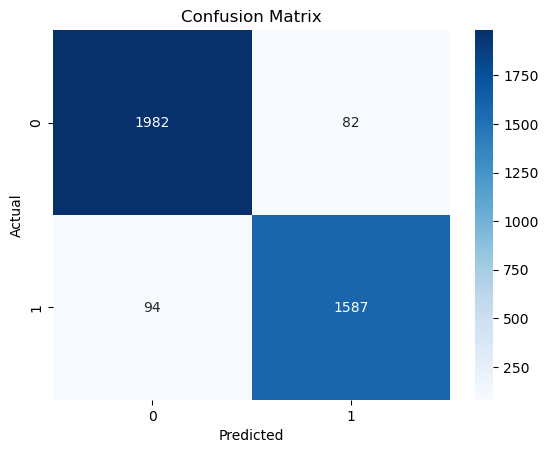

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2064
           1       0.95      0.94      0.95      1681

    accuracy                           0.95      3745
   macro avg       0.95      0.95      0.95      3745
weighted avg       0.95      0.95      0.95      3745



In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

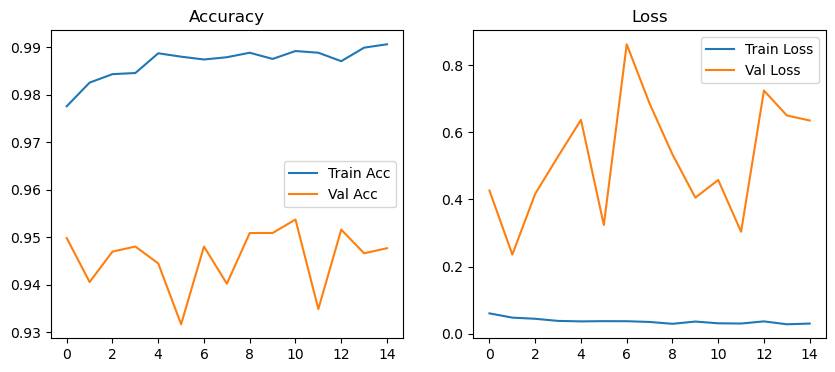

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()